## Taller 1 – EDA-Florida-AndresGutierrez

En este juego de roles, como consultor científico de datos, el objetivo es ayudar a individuos o empresas que buscan invertir en propiedades de alquiler a través de la plataforma Airbnb. La meta es lograr una rentabilidad adecuada a lo largo del tiempo, la cual puede estar dada en términos de una alta tasa de ocupación y precio por noche.

Este notebook contiene información de Airbnb en **Florida**, y se abordará el problema con el siguiente enfoque:



### Preguntas clave:
   - ¿Qué tipos de propiedades son más populares o tienen mayor demanda?
   - ¿Cuáles son las zonas o ubicaciones más rentables? (esto implica crear una variable).
   - ¿Cómo influyen las calificaciones en la tasa de ocupación o en el precio por noche?



# Setup

In [1]:

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Florida"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Get the data

In [2]:
import pandas as pd

# import data from a csv
listings = pd.read_csv('data/listings.csv')


In [3]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

*Se seleccionan del set de datos las variables para trabajar*

In [4]:
# Identifier column
identifier = 'id'

# Features related to the property details
property_features = ['property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'longitude', 'latitude']

# Features related to reviews and ratings
reviews_features = ['number_of_reviews_l30d', 'reviews_per_month', 'review_scores_rating', 'review_scores_location','review_scores_cleanliness','review_scores_checkin','review_scores_value','instant_bookable','number_of_reviews_ltm']

# Features related to host
host_features = ['host_acceptance_rate']

# Combining the features into one list
all_features = [identifier] + property_features + reviews_features + host_features

listings = listings[all_features].copy()

# Display the first rows of the adjusted DataFrame
listings.head()

,id,property_type,room_type,accommodates,bedrooms,beds,price,longitude,latitude,number_of_reviews_l30d,reviews_per_month,review_scores_rating,review_scores_location,review_scores_cleanliness,review_scores_checkin,review_scores_value,instant_bookable,number_of_reviews_ltm,host_acceptance_rate
0,57818,Entire home,Entire home/apt,4,2.0,2.0,$275.00,-80.12430,26.01859,0,0.45,4.63,4.88,4.61,5.00,4.71,f,1,97%
1,83449,Entire rental unit,Entire home/apt,5,2.0,3.0,$91.00,-80.14201,26.03392,0,0.20,4.74,4.81,4.85,4.93,4.85,f,8,95%
2,3097603,Entire rental unit,Entire home/apt,8,2.0,1.0,$300.00,-80.37207,26.12660,0,NaN,NaN,NaN,NaN,NaN,NaN,f,0,NaN
3,3105046,Entire rental unit,Entire home/apt,4,1.0,1.0,$105.00,-80.37142,26.12751,0,NaN,NaN,NaN,NaN,NaN,NaN,f,0,NaN
4,3113463,Private room in home,Private room,2,NaN,1.0,$65.00,-80.13118,26.20928,1,0.76,4.92,4.78,4.93,4.97,4.97,t,5,100%


In [5]:
# Showing dataframe dimensions, Dtype column types and not null values
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17728 entries, 0 to 17727
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         17728 non-null  int64  
 1   property_type              17728 non-null  object 
 2   room_type                  17728 non-null  object 
 3   accommodates               17728 non-null  int64  
 4   bedrooms                   14715 non-null  float64
 5   beds                       17567 non-null  float64
 6   price                      17728 non-null  object 
 7   longitude                  17728 non-null  float64
 8   latitude                   17728 non-null  float64
 9   number_of_reviews_l30d     17728 non-null  int64  
 10  reviews_per_month          14293 non-null  float64
 11  review_scores_rating       14293 non-null  float64
 12  review_scores_location     14253 non-null  float64
 13  review_scores_cleanliness  14254 non-null  flo

In [6]:
listings.describe()

,id,accommodates,bedrooms,beds,longitude,latitude,number_of_reviews_l30d,reviews_per_month,review_scores_rating,review_scores_location,review_scores_cleanliness,review_scores_checkin,review_scores_value,number_of_reviews_ltm
count,1.772800e+04,17728.000000,14715.000000,17567.000000,17728.000000,17728.000000,17728.000000,14293.000000,14293.000000,14253.000000,14254.000000,14254.000000,14254.000000,17728.000000
mean,3.884334e+17,5.128667,2.191981,2.933227,-80.145691,26.103619,0.748703,1.561535,4.681931,4.777781,4.694178,4.787049,4.639103,10.341494
std,3.842290e+17,3.102829,1.351469,2.096210,0.056124,0.098854,1.485483,1.638520,0.538619,0.377275,0.471557,0.450133,0.487447,16.555148
min,5.781800e+04,0.000000,1.000000,1.000000,-80.428780,25.957040,0.000000,0.010000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,4.407362e+07,2.000000,1.000000,1.000000,-80.155632,26.008446,0.000000,0.470000,4.600000,4.720000,4.600000,4.750000,4.530000,0.000000
50%,5.581943e+17,4.000000,2.000000,2.000000,-80.126230,26.112820,0.000000,1.140000,4.830000,4.880000,4.830000,4.940000,4.760000,4.000000
75%,7.702069e+17,6.000000,3.000000,4.000000,-80.116354,26.173360,1.000000,2.220000,5.000000,5.000000,5.000000,5.000000,4.920000,15.000000
max,9.210765e+17,16.000000,13.000000,21.000000,-80.074910,26.334900,61.000000,74.890000,5.000000,5.000000,5.000000,5.000000,5.000000,858.000000


## Univariate analysis

In [7]:
# Duplicated rows
listings.duplicated().sum()

0

In [8]:
# Transform the price attribute from object to float
listings["price_float"] = listings["price"].str.replace("[$,]", "", regex=True).astype(float)

# Calculate the Interquartile Range (IQR) for the price_float column
q1 = listings["price_float"].quantile(0.25)
q3 = listings["price_float"].quantile(0.75)
iqr = q3 - q1

# Define bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter the DataFrame to exclude outliers based on the price_float column
filtered_listings = listings[ listings["price_float"] <= upper_bound]

# Display the shape of the original and filtered DataFrames
original_shape = listings.shape
filtered_shape = filtered_listings.shape

print(original_shape, filtered_shape)

(17728, 20) (16379, 20)


[]

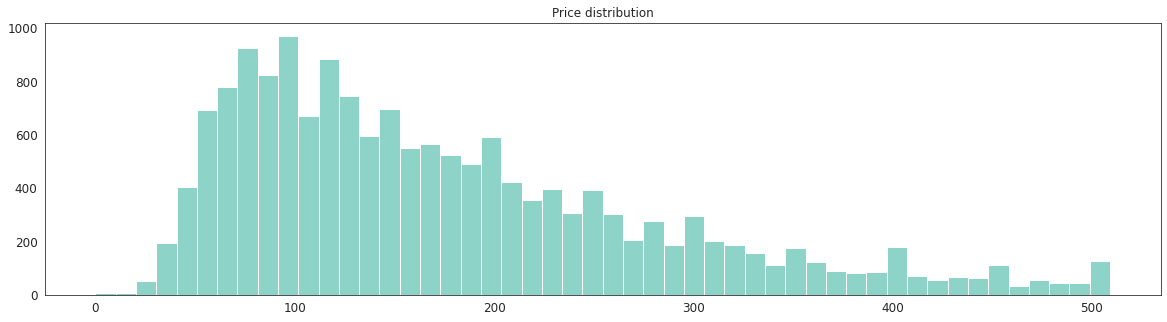

In [9]:
import seaborn as sns
# Select numeric columns from the listings DataFrame
numeric_columns = filtered_listings.select_dtypes(include=['float64', 'int64']).columns
sns.set_style("white")
plt.figure(figsize=(20, 5))
plt.hist(filtered_listings["price_float"], bins=50)
plt.title("Price distribution")
plt.plot()

In [10]:
1-filtered_listings.shape[0]/listings.shape[0]

0.07609431407942235

### Processing missing values

Hay 10376 filas sin valores faltantes en el dataset.


<AxesSubplot:>

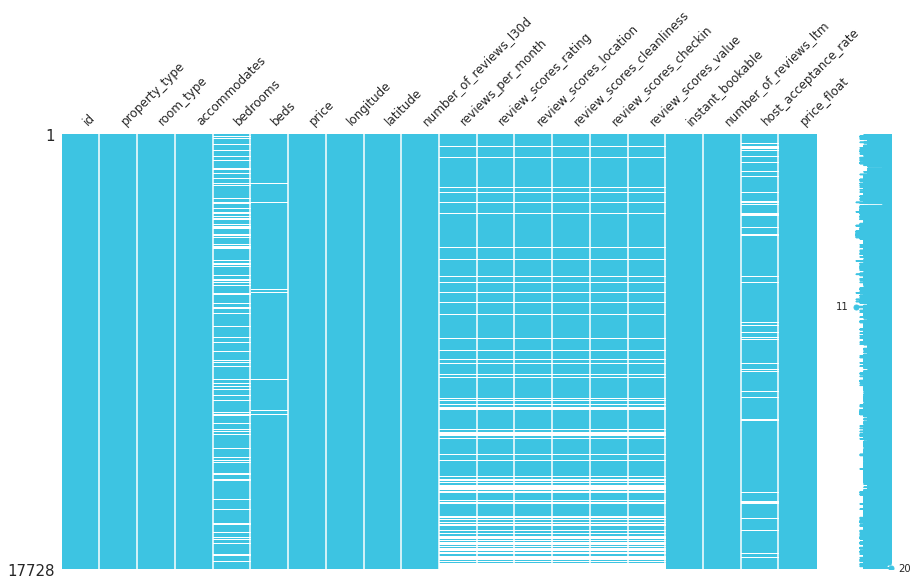

In [11]:

import missingno as msno

missing_data = filtered_listings.isnull()


complete_rows = filtered_listings.dropna()

num_complete_rows = len(complete_rows)

# Configurar el fondo blanco en Seaborn
sns.set_style("white")
print(f"Hay {num_complete_rows} filas sin valores faltantes en el dataset.")
msno.matrix(listings, figsize=(15, 8), color=(0.24, 0.77, 0.89), fontsize=12)



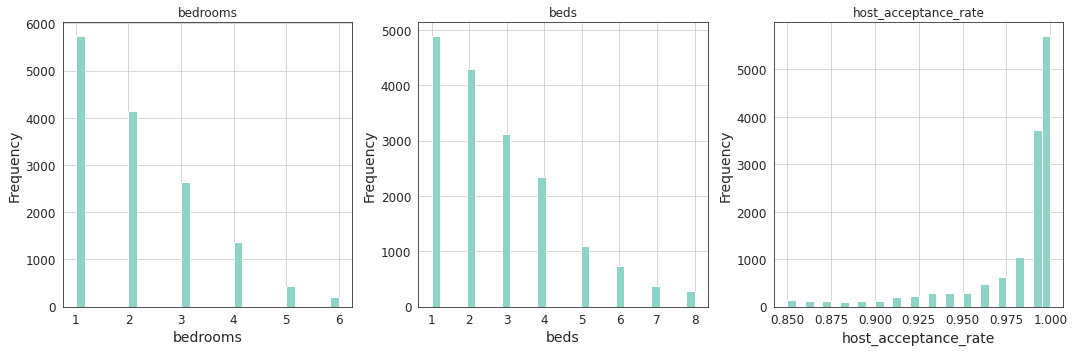

In [12]:
# List of specified columns
columns_to_process = ['bedrooms', 'beds', 'host_acceptance_rate']

# Function to filter outliers based on IQR
def filter_outliers(df, column_name):
    # For the host_acceptance_rate column, convert percentage strings to float
    if column_name == "host_acceptance_rate":
        df[column_name] = df[column_name].str.rstrip('%').astype('float') / 100.0
    
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Dictionary to store filtered dataframes for each column
filtered_dfs = {}

for column in columns_to_process:
    filtered_dfs[column] = filter_outliers(listings.copy(), column)

# Plot histograms for the specified columns after filtering outliers
plt.figure(figsize=(15, 5))
for index, column in enumerate(columns_to_process, 1):
    plt.subplot(1, 3, index)
    filtered_dfs[column][column].hist(bins=30)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Imputar los valores faltantes de bedrooms utilizando la media, excluyendo los valores atípicos.  
Basándose en los bedrooms ya imputados, imputar los valores faltantes de beds utilizando la media, excluyendo los valores atípicos.  
Luego, para los valores faltantes restantes de bedrooms, imputar utilizando la media basada únicamente en los datos que son considerados outliers de bedrooms.  
Luego, para los valores faltantes restantes de beds, imputar utilizando la media basada únicamente en los datos que son considerados outliers de beds.  
Imputar los valores faltantes en la columna host_acceptance_rate usando la mediana.

In [15]:
# 1. Impute missing values in 'bedrooms' using the mean (excluding outliers)
mean_bedrooms_without_outliers = filter_outliers(listings, 'bedrooms')['bedrooms'].mean()
listings.loc[listings['bedrooms'].isnull(), 'bedrooms'] = listings['bedrooms'].fillna(mean_bedrooms_without_outliers)

# 2. Based on the already imputed 'bedrooms', impute missing values in 'beds' using the mean (excluding outliers)
beds_mean_per_bedroom_without_outliers = filter_outliers(listings, 'beds').groupby('bedrooms')['beds'].transform('mean')
listings.loc[listings['beds'].isnull(), 'beds'] = listings['beds'].fillna(beds_mean_per_bedroom_without_outliers)

# 3. For remaining missing values in 'bedrooms', impute using the mean based only on outlier data of 'bedrooms'
mean_bedrooms_with_outliers = listings[~listings.index.isin(filter_outliers(listings, 'bedrooms').index)]['bedrooms'].mean()
listings['bedrooms'].fillna(mean_bedrooms_with_outliers, inplace=True)

# 4. For remaining missing values in 'beds', impute using the mean based only on outlier data of 'beds'
beds_mean_per_bedroom_with_outliers = listings[~listings.index.isin(filter_outliers(listings, 'beds').index)].groupby('bedrooms')['beds'].transform('mean')
listings['beds'].fillna(beds_mean_per_bedroom_with_outliers, inplace=True)

# 5. Impute missing values in 'host_acceptance_rate' with the median
# Convert host_acceptance_rate column from string percentages to float
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
median_host_acceptance_rate = listings['host_acceptance_rate'].median()
listings['host_acceptance_rate'].fillna(median_host_acceptance_rate, inplace=True)


# Check if there are still missing values in these columns
missing_values_after_restructured_imputation = {
    'bedrooms': listings['bedrooms'].isnull().sum(),
    'beds': listings['beds'].isnull().sum(),
    'host_acceptance_rate': listings['host_acceptance_rate'].isnull().sum()
}

missing_values_after_restructured_imputation


{'bedrooms': 0, 'beds': 0, 'host_acceptance_rate': 0}

In [17]:
listings.reviews_per_month

0        0.45
1        0.20
2         NaN
3         NaN
4        0.76
         ... 
17723     NaN
17724     NaN
17725     NaN
17726     NaN
17727     NaN
Name: reviews_per_month, Length: 17728, dtype: float64

## Univariate analysis

Vamos a crear dos variable extras que son la "demand" y el "annual_income"